<a href="https://colab.research.google.com/github/marcinwolter/Tracking_student2022/blob/main/GNN_MuonE_v1_Robust_mc_recon_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

# Code performing the pattern recognition only
### All strip hits are used for patern recognition in 3D (each hit is xz, yz, uz or vz). The ratio of wrongly recognized edges is about 2.5 promile

22.11.2023 Marcin Wolter

In [1]:
#!pip uninstall torchvision torchtext torchaudio  --yes
#!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [3]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

2.1.0+cu121
PyTorch version: None , CUDA version: 12.1


In [4]:

#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
#!pip install torch-geometric

# MW corrected for http://192.86.14.64/ jupyter
#!pip3 install --upgrade torch torchvision torchaudio
#!pip3 install --upgrade pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [5]:

from torch_geometric.data import Data

from torch_geometric.data import DataLoader
import torch.nn as nn

from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


## The Problem

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""

    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers

    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())

    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True,normalize_factor= 1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        self.normalize_factor=normalize_factor
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)
        
        # Encode the graph features into the hidden space
        #print( torch.mean (data.x[:,0]) )
        #print( torch.mean (data.x[:,1]) )
        if self.normalize_factor!=1:
          temp = data.x.clone().detach()
          temp[:,1] *= self.normalize_factor
          x = self.node_encoder(temp)
        else:
          x = self.node_encoder(data.x.clone().detach())
        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [7]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

### Training and Validation Functions


In [8]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [9]:
def predict(model, test_loader, cut=0.5):
    y_pred = []
    y_true = []
    ii = 0

    print(len(test_loader.dataset))
#    for k in range(len(test_loader.dataset)):
#        data = test_loader.dataset[k].to(device)
#        pred = torch.sigmoid(model(data)).to('cpu')
    for batch in test_loader:
        data = batch.to(device)
        pred = torch.sigmoid(model(data)).to('cpu')
        #print("MWM ", pred, len(pred))
        #print("MWMW ", data.y, len(data.y))  
        y_pred.extend([p>cut for p in pred])
            
        y_true.extend(data.y.to('cpu'))
        ii+=1
    print(ii)
    y_pred = np.array(y_pred, dtype=int)
    y_true = np.array(y_true, dtype=int)

    return y_pred, y_true

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [10]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests. Try playing with more hidden node and edge dimensions (e.g. 64) and see if the message passing iterations can improve the performance.



# **Load MuonE data and reconstruct tracks**

In [11]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [12]:
# Circle parameters
num_layers = 14
height, width = 10, 10
#min_curve, max_curve =  1000, 1001 # 15, 50

#max_angle = (0.05)*np.pi
max_angle = (1.)*np.pi
feature_scale = 200.

In [13]:
import numpy as np
import pandas as pd

  
def readMuonE(event_file,is_x=True, both_xy=False):


   data = pd.read_csv(event_file) 
   #data = pd.read_csv(event_file,engine='python')   
   # Preview the first 5 lines of the loaded data 
   print(data.head(30))

   if is_x:
    axis_oi=0
    layerZ0 =  [-999, -21, 151, 497, 843.7, 1141, 1266, 1960 ]
   else :
    layerZ0 =  [-16, 131, 477, 832, 1146, 1479.6, 1973 ]
    axis_oi=1
    
   if both_xy:
    layerZ0 =  [-999, -21, -16, 131, 151, 477, 497, 832, 843.7, 1141, 1146, 1252.7, 1266, 1467.4, 1479.6, 1960, 1973 ]

    
   # Temporary nextZ  (next layer Z)
   #layerZ0 =  [-999, -16, -21, 131, 151, 477, 497, 832, 843.7, 1146, 1252.7, 1266, 1960, 1973 ]


   #X = np.array([[0,0,0]])
   #print(X)
   
   
   iEventLast=data.iat[0,0]
   k=0
   Xcreated=False
   #dataOUTcreated=False
   dataOUT = []

   imw=0 
   #iterate over input data
   for k, row in data.iterrows():
     ll=data.iat[k,0]
     #print("counter ",k,ll,iEventLast)
     if ll != iEventLast:

       '''
       for layer in np.arange(num_layers-1):
          print("XX=",layer,X)
          for i in np.argwhere(X[:,2] == layerZ0[layer+1]): 
            for j in np.argwhere(X[:,2] == layerZ0[layer+3]):
               if (X[i, 0] - 20. < X[j, 0] < X[i, 0] + 20.):
                   print("layer, i, j=",layer, i, j)
       '''
#       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2))  if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()
       if imw<4: 
           print(X) 
       if both_xy:
           e = np.array([[i,j] for layer in np.arange(len(layerZ0)-1) for i in np.argwhere(X[:,2] == 
              layerZ0[layer]) for j in np.argwhere(X[:,2] == layerZ0[layer+1])  
                        ]).T.squeeze()
       else: 
           e = np.array([[i,j] for layer in np.arange(len(layerZ0)-1) for i in np.argwhere(X[:,2] == 
              layerZ0[layer]) for j in np.argwhere(X[:,2] == layerZ0[layer+1])  
                     if (X[i, 0] - np.tan(max_angle/2)*(layerZ0[layer+1]-layerZ0[layer]) < X[j, 0] 
                                < X[i, 0] + np.tan(max_angle/2)*(layerZ0[layer+1]-layerZ0[layer]))]).T.squeeze()
       imw += 1
       if imw<5: 
           print(e) 
#       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == 
 #             layerZ0[layer+1]) for j in np.argwhere(X[:,2] == layerZ0[layer+3])  if (X[i, 0] - np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]) < X[j, 0] < X[i, 0] + np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]))]).T.squeeze()


       #print(X)
       #print("e ",e) 
        # This handles when no edges were constructed. In that case, the randomisation is a do-over
       #try:
       y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])
       #     print("y = ",y)     
       #     break
       #except:
       #     pass

       #print("y = ",y) 
       #if iter is not None and num_samples is not None:
       #     out.update(progress(iter, num_samples))    


       X = np.array([X[:,2], X[:,0]]).T / feature_scale

       dataEvent = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1])  )

       #plot_toy_graph(dataEvent, 0.2)

       dataOUT.append(dataEvent)
#       if dataOUTcreated:
#         dataOUT = dataOUT.append(dataEvent)
#       else:
#         dataOUT = dataEvent 
#         dataOUTcreated = True

       Xcreated = False  
       iEventLast = ll

     #print(len(X)) 
     #print(k,ll,data.iat[k,2],Xcreated) 
     if both_xy:   
      if data.iat[k,5]<3 and data.iat[k,5]>=0: #remove equal to part if you don't want to  # select X-hit and trackID=0,1,2
        if Xcreated:
          X = np.append(X,np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]),axis=0)
        else:
          X = np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]) 
          Xcreated=True
          #print("X created ",X)
     else:
      if data.iat[k,2]==axis_oi and data.iat[k,5]<3 and data.iat[k,5]>=0: #remove equal to part if you don't want to  # select X-hit and trackID=0,1,2
        if Xcreated:
          X = np.append(X,np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]),axis=0)
        else:
          X = np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]) 
          Xcreated=True
          #print("X created ",X)   
     
   return dataOUT       





#Reads original monte carlo File

def readMCtrack(event_file, is_x= True ):

  data = pd.read_csv(event_file) 
  #data = pd.read_csv(event_file,engine='python')  
  # Preview the first 5 lines of the loaded data 
  data.head()

  if is_x:
    axis_oi=[4,1]
  else  :
    axis_oi=[5,2]

  temp=data.iat[-1,0]
  track_slopes=torch.zeros(temp,6)

  for k, row in data.iterrows():

    if (data.iat[k,7]==np.array([0,1,2])).any():

      

      if track_slopes.shape[0]< data.iat[k,0]-1 :
        track_slopes=torch.cat([track_slopes,torch.zeros(1,6)],dim=0)
      
      
      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2 ] = data.iat[k,axis_oi[0]]/data.iat[k,6]

      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2+1] =  data.iat[k,axis_oi[1]] - data.iat[k,axis_oi[0]]/data.iat[k,6]  * data.iat[k,3]
  
  return track_slopes










# Reads From Reconstruction File

def ReadRecon(event_file,is_x=True):
  data = pd.read_csv(event_file)  
  #data = pd.read_csv(event_file,engine='python')
  data.head()

  if is_x:
    axis_oi=[3,1,7,5,9]
  else:
    axis_oi=[4,2,8,6,9]

  track_=torch.zeros(data.iat[-1,0],10)

  for k,row in enumerate(data.iterrows()):

    if k % 2 ==0:
      #track_[data.iat[k,0]-1,0],track_[data.iat[k,0]-1,1]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i]=data.iat[k,axis_oi[i]]
    else:
      #track_[data.iat[k,0]-1 ,2],track_[data.iat[k,0]-1,3]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i+5]=data.iat[k,axis_oi[i]]
  print(k)
  

  temp=track_.clone()
  for i in range(data.iat[-1,0]):
    if torch.abs(temp[i,0])>torch.abs(temp[i,5]):

      track_[i,0:4]=temp[i,5:9]
      track_[i,5:9]=temp[i,0:4]



  return track_





In [14]:
# Read data and prepare for training

is_x = True
both_xy = True
axis = is_x

event_file_MC= "/storage/MUonE/mwolter/MuonE_tracking/MCtrackFile_big.csv"
event_file= "/storage/MUonE/mwolter/MuonE_tracking/hitFile_big.csv"
event_file_recon= "/storage/MUonE/mwolter/MuonE_tracking/trackFile_big.csv"
#event_file_MC= "/storage/MUonE/mwolter/MuonE_tracking/MCtrackFile_medium.csv"
#event_file= "/storage/MUonE/mwolter/MuonE_tracking/hitFile_medium.csv"
#event_file_recon= "/storage/MUonE/mwolter/MuonE_tracking/trackFile_medium.csv"
#event_file_MC= "/storage/MUonE/mwolter/MuonE_tracking/MCtrackFile_small.csv"
#event_file= "/storage/MUonE/mwolter/MuonE_tracking/hitFile_small.csv"
#event_file_recon= "/storage/MUonE/mwolter/MuonE_tracking/trackFile_small.csv"

Tracks=readMCtrack(event_file_MC,axis)
data = readMuonE(event_file,axis, both_xy)
Tracks_recon=ReadRecon(event_file_recon,axis)

#Tracks_x=readMCtrack(event_file_MC,is_x)
#data_x = readMuonE(event_file,is_x)
#Tracks_recon_x=ReadRecon(event_file_recon,is_x)

# split data into training and test datasets
train_dataset,test_dataset,test_tracks,train_tracks,train_recon,test_recon = [],[],[],[],[],[]

for k in range(len(data)):
  if (k%4 == 0):
    test_dataset.append(data[k])
    test_tracks.append(Tracks[k,:])
    test_recon.append(Tracks_recon[k,:])
  else:
    train_dataset.append(data[k])
    train_tracks.append(Tracks[k,:])
    train_recon.append(Tracks_recon[k,:])
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)    

# Display few events
#for k in range(10):
 #  plot_toy_graph(train_loader.dataset[k], 0.2)


print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("Fake / True = ", (len(test_dataset[0].y) - test_dataset[0].y.sum().item()) / test_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

    nEvent         hitPos   hitType   layerZ   layerIndex   trackID 
0         1  2.826200e-05         1    -16.0            0          0
1         1 -9.032680e-07         0    -21.0            1          0
2         1  1.956890e-03         1    131.0            2          0
3         1 -1.329020e-03         0    151.0            3          0
4         1  1.020050e-02         1    477.0            4          0
5         1 -4.013290e-03         0    497.0            5          0
6         1  6.936620e-01         1    832.0            6          2
7         1 -5.503250e-02         1    832.0            6          1
8         1  4.251230e+00         0    843.7            7          2
9         1 -1.353290e-01         0    843.7            7          1
10        1  1.353980e+00         1   1146.0            8          2
11        1 -1.114350e-01         1   1146.0            8          1
12        1  8.254280e+00         0   1141.0            9          2
13        1 -2.633850e-01         

/home/jupyter-mwolter/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [15]:
def plot_toy_graph(event, ylim=0.):
  
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
#     for i, j in zip(X[e[0]], X[e[1]]):
#         plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    if (ylim!=0):
       plt.ylim(-ylim,ylim)
    else:
       diff = 0.1*(max(y)-min(y))
       plt.ylim(min(y)-diff, max(y)+diff)   

 k =  0 tensor([[-8.0000e-02, -8.9323e-08],
        [-1.0500e-01,  2.4170e-09],
        [ 6.5500e-01, -1.8753e-06],
        [ 7.5500e-01,  8.9814e-06],
        [ 2.3850e+00,  7.3382e-06],
        [ 2.4850e+00,  4.1770e-05],
        [ 4.1600e+00, -6.6870e-03],
        [ 4.1600e+00, -6.0837e-04],
        [ 4.2185e+00, -1.9652e-02],
        [ 4.2185e+00, -4.5710e-04],
        [ 5.7300e+00, -1.3965e-02],
        [ 5.7300e+00, -1.2507e-03],
        [ 5.7050e+00, -3.8482e-02],
        [ 5.7050e+00, -9.0835e-04],
        [ 6.2635e+00, -4.3954e-02],
        [ 6.2635e+00, -1.7997e-03],
        [ 6.3300e+00, -4.6363e-02],
        [ 6.3300e+00, -1.0991e-03],
        [ 7.3980e+00, -2.2518e-02],
        [ 7.3980e+00, -1.9224e-03],
        [ 7.3370e+00, -2.5973e-02],
        [ 7.3370e+00,  3.5241e-04],
        [ 9.8650e+00, -3.5492e-02],
        [ 9.8650e+00, -2.9255e-03],
        [ 9.8000e+00, -8.9815e-02],
        [ 9.8000e+00, -2.1199e-03]])
 k =  1 tensor([[-8.0000e-02, -5.0844e-08],
        [-1

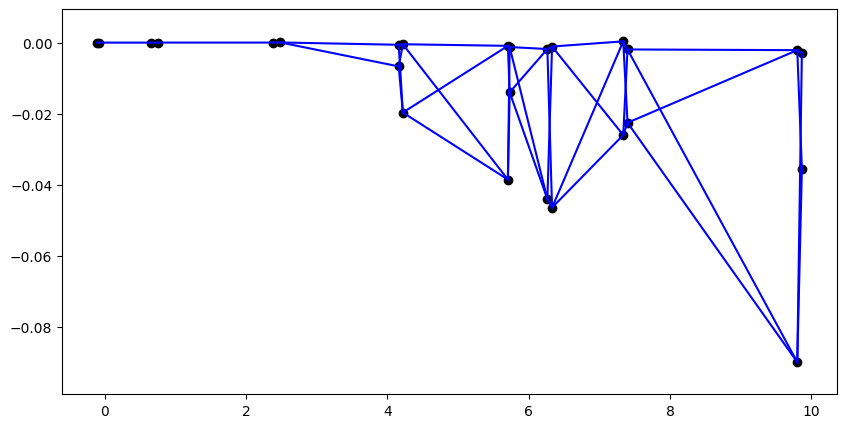

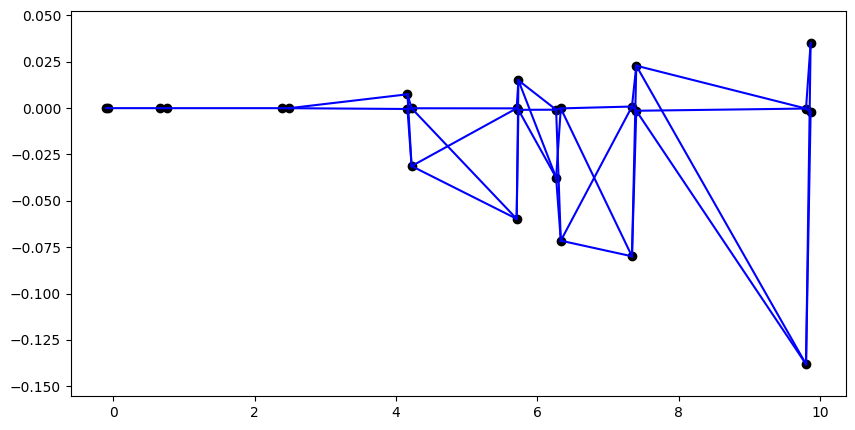

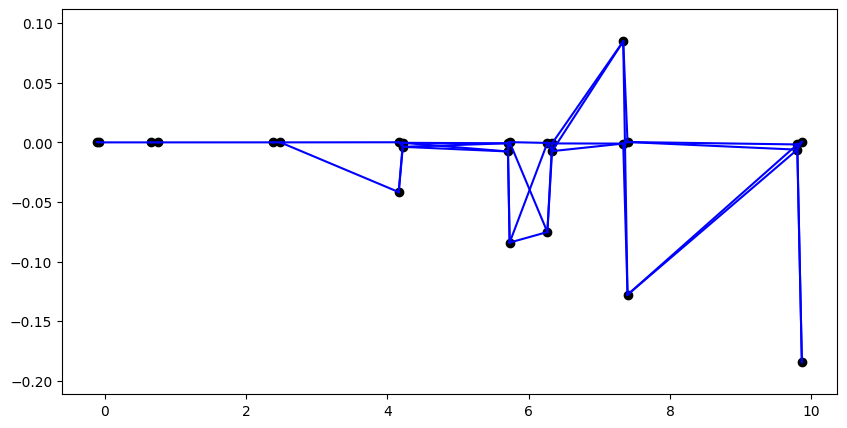

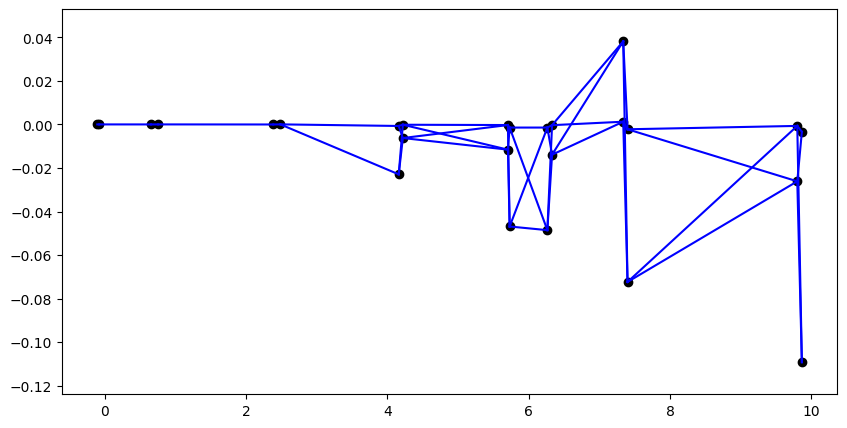

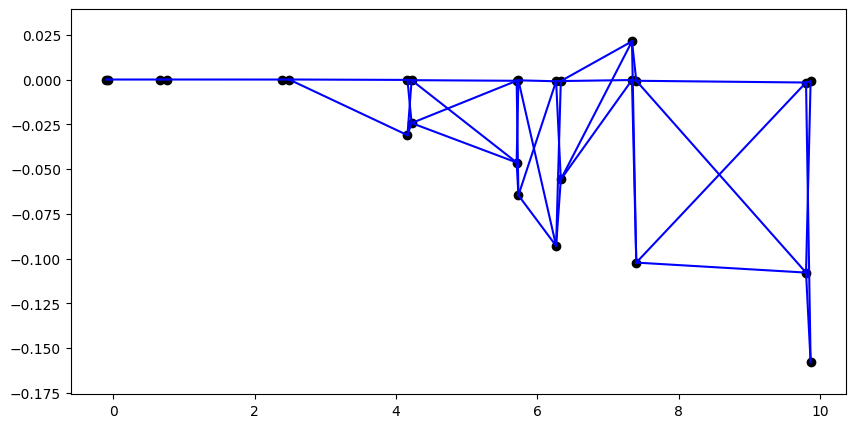

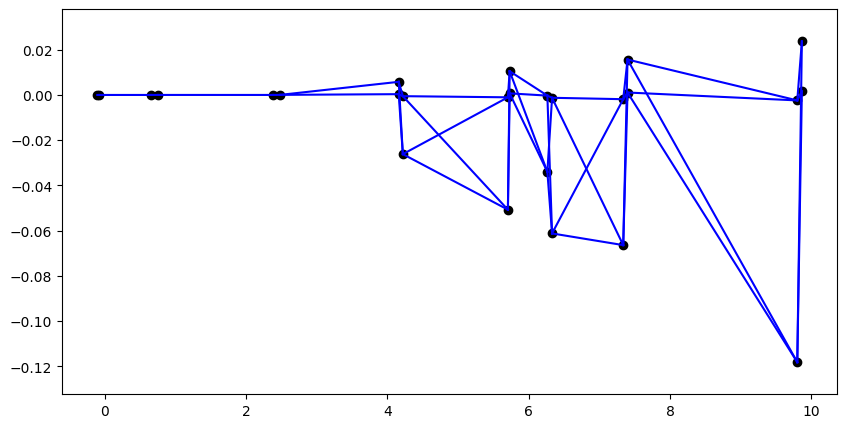

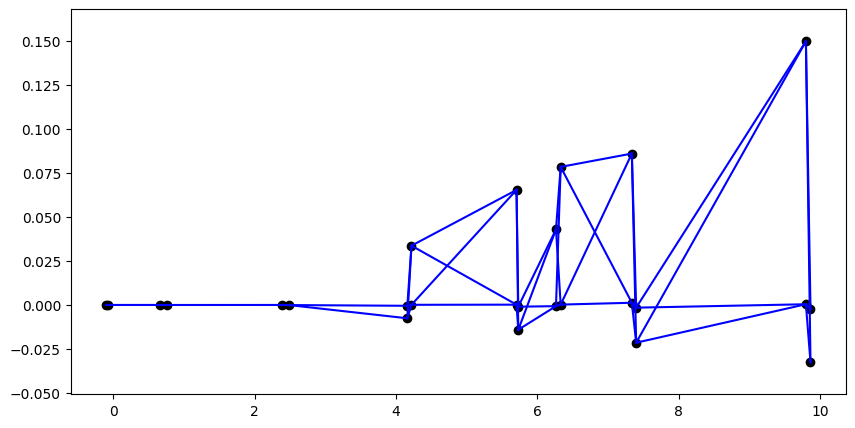

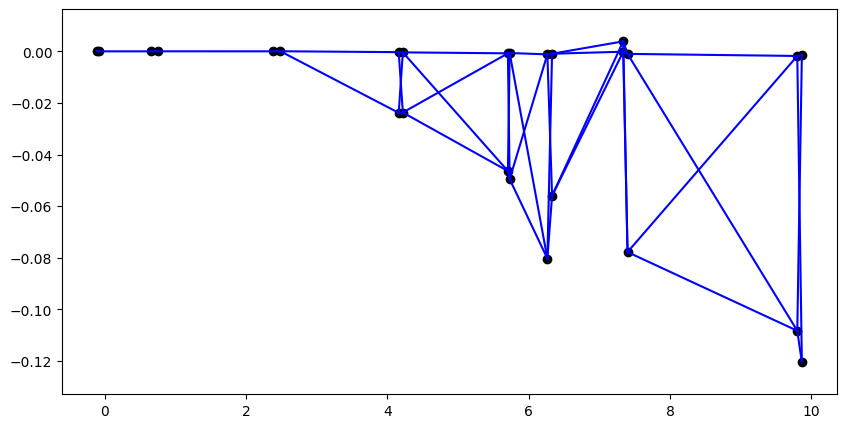

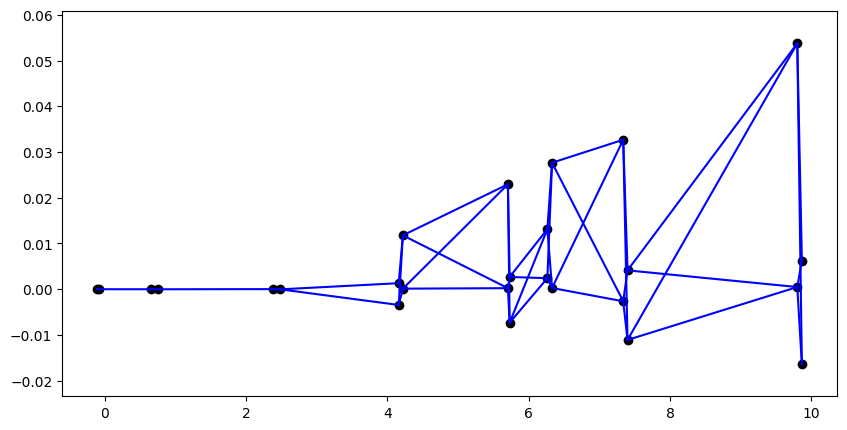

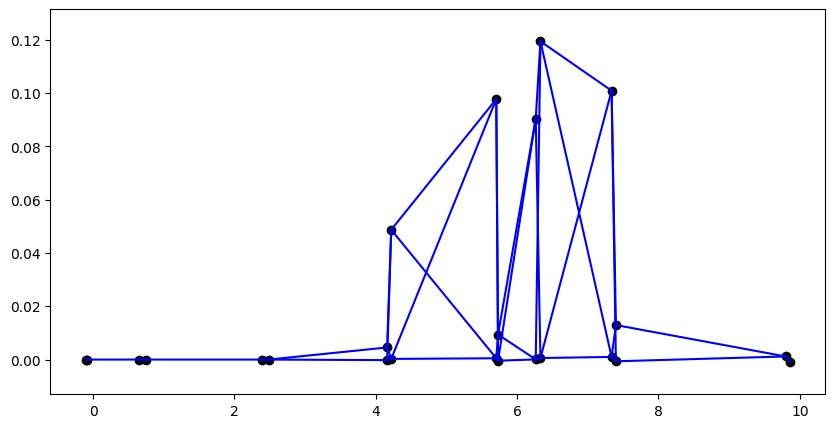

In [16]:

# Display few events
for k in range(10):
   print(" k = ",k,train_loader.dataset[k].x) 
   plot_toy_graph(train_loader.dataset[k], 0.)



print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

# **Simple GNN**

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [17]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = 1

#device = torch.device('cpu')

#m_configs = {'normalize_factor': 2000 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
m_configs = {'normalize_factor': 2000 ,"input_dim": 2, "hidden_node_dim": 128, "hidden_edge_dim": 256, "in_layers": 4, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

epochs = 500
for epoch in range(epochs):
    ep += 1  
    model.train()
    acc_t, loss_t = train(model, train_loader, optimizer)
    t_loss_v.append(loss_t)
    t_acc_v.append(acc_t)

    model.eval()
    acc, loss = evaluate(model, test_loader)
    v_loss_v.append(loss)
    v_acc_v.append(acc)
    if ep % 10 == 1 or True :
      print(
       'Epoch: {}, Train acc: {:.4f}, val. acc: {:.4f}, train loss: {:.4f}, val. loss: {:.4f}'.format(ep, acc_t, acc, loss_t, loss))


/home/jupyter-mwolter/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch: 1, Train acc: 0.9619, val. acc: 0.9817, train loss: 53.4190, val. loss: 7.8739
Epoch: 2, Train acc: 0.9822, val. acc: 0.9827, train loss: 23.2739, val. loss: 9.6784
Epoch: 3, Train acc: 0.9848, val. acc: 0.9850, train loss: 20.1755, val. loss: 6.8827
Epoch: 4, Train acc: 0.9860, val. acc: 0.9883, train loss: 18.7050, val. loss: 5.2668
Epoch: 5, Train acc: 0.9876, val. acc: 0.9846, train loss: 16.9080, val. loss: 7.4649
Epoch: 6, Train acc: 0.9883, val. acc: 0.9877, train loss: 16.1540, val. loss: 5.4692
Epoch: 7, Train acc: 0.9896, val. acc: 0.9874, train loss: 14.5235, val. loss: 5.7396
Epoch: 8, Train acc: 0.9901, val. acc: 0.9907, train loss: 13.9118, val. loss: 4.3821
Epoch: 9, Train acc: 0.9905, val. acc: 0.9918, train loss: 13.4148, val. loss: 3.9525
Epoch: 10, Train acc: 0.9908, val. acc: 0.9887, train loss: 12.9009, val. loss: 5.4685
Epoch: 11, Train acc: 0.9911, val. acc: 0.9893, train loss: 12.4899, val. loss: 4.8108
Epoch: 12, Train acc: 0.9918, val. acc: 0.9915, trai

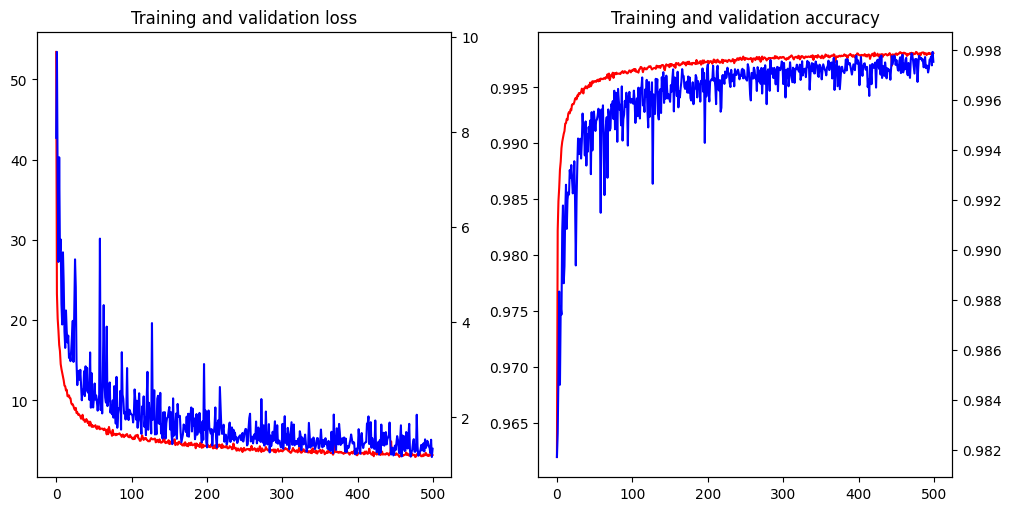

In [18]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v,"r")
axs[0].twinx().plot(np.arange(len(v_loss_v)), v_loss_v, "b")
axs[0].set_title("Training and validation loss")
axs[0].set_yscale("linear")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, "r")
axs[1].twinx().plot(np.arange(len(v_acc_v)), v_acc_v, "b")
axs[1].set_title("Training and validation accuracy")
axs[1].set_yscale("linear")

24982
250
[[497717   1251]
 [  1318 572803]]


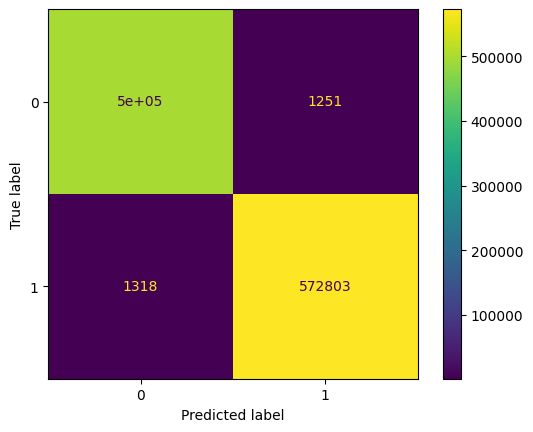

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred, y_true = predict(model, test_loader, cut=0.5)
cf = confusion_matrix(y_true, y_pred)
print(cf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


